Bounding Box: x_min=23, y_min=31, x_max=277, y_max=241


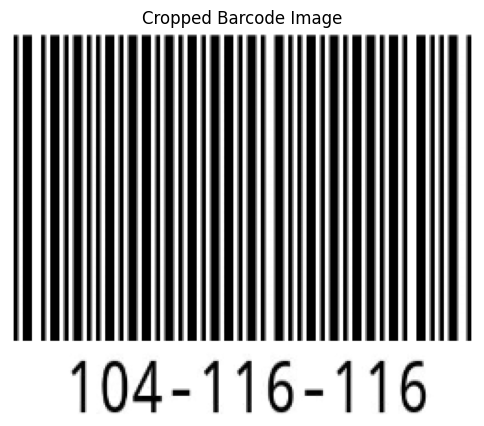

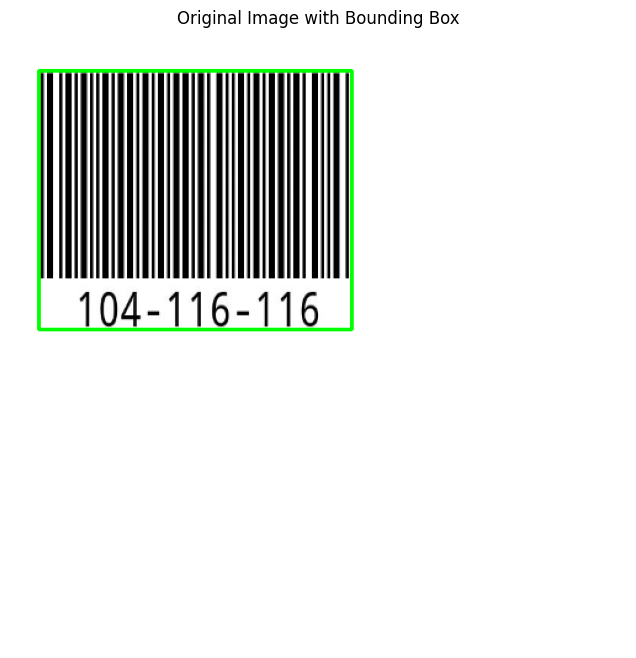

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_barcode_image(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image file not found. Make sure the path is correct.")

    # Resize for performance (optional)
    image = cv2.resize(image, (500, 500))

    # Step 1: Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)

    # Step 2: Compute gradients
    grad_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x) * (180.0 / np.pi)
    direction[direction < 0] += 180

    # Step 3: Non-maximum suppression (optimized)
    nms_image = np.zeros_like(magnitude, dtype=np.uint8)
    rows, cols = magnitude.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            angle = direction[i, j]
            q, r = 255, 255
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                q = magnitude[i, j + 1]
                r = magnitude[i, j - 1]
            elif 22.5 <= angle < 67.5:
                q = magnitude[i + 1, j - 1]
                r = magnitude[i - 1, j + 1]
            elif 67.5 <= angle < 112.5:
                q = magnitude[i + 1, j]
                r = magnitude[i - 1, j]
            elif 112.5 <= angle < 157.5:
                q = magnitude[i - 1, j - 1]
                r = magnitude[i + 1, j + 1]
            if magnitude[i, j] >= q and magnitude[i, j] >= r:
                nms_image[i, j] = magnitude[i, j]

    # Step 4: Double thresholding
    low_threshold = 50
    high_threshold = 150
    strong_pixel = 255
    weak_pixel = 75
    strong_edges = (nms_image >= high_threshold)
    weak_edges = ((nms_image >= low_threshold) & (nms_image < high_threshold))
    thresh_image = np.zeros_like(nms_image, dtype=np.uint8)
    thresh_image[strong_edges] = strong_pixel
    thresh_image[weak_edges] = weak_pixel

    # Steps of Contour Analysis
    # Step 1: Find Contours
    contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 2: Analyze Contours to find the bounding rectangle encompassing the full barcode
    x_min, y_min = float('inf'), float('inf')
    x_max, y_max = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    # Ensure we have valid coordinates for the bounding box
    if x_min < x_max and y_min < y_max:
        print(f"Bounding Box: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")

        # Crop the image to the bounding box
        cropped_image = image[y_min:y_max, x_min:x_max]

        # Display the cropped image
        plt.figure(figsize=(6, 6))
        plt.title("Cropped Barcode Image")
        plt.imshow(cropped_image, cmap='gray')
        plt.axis("off")
        plt.show()

        # Visualize the bounding box on the original image
        output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color image for visualization
        cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        plt.figure(figsize=(8, 8))
        plt.title("Original Image with Bounding Box")
        plt.imshow(output_image)
        plt.axis("off")
        plt.show()

        return cropped_image
    else:
        print("No valid bounding box found.")
        return None

# Example usage:
cropped = process_barcode_image('02 - still easy.jpg')
